
> *Coil field:* $$f(d) = \frac{k}{d^n}$$

> $n$ is the propagation constant

> *2D space:* $$f(x,y) = \frac{k}{(x^2+y^2)^{\frac{n}{2}}}$$

> *convert into dB:* $$RSS(d) = log(f(d))$$

> $$RSS(d) = log(k) - \frac{1}{n}log(d)$$

> $$RSS(d) = A - \frac{1}{n}log(d)$$ where $A = log(k)$

> **Trick:** to avoid infinity change $f$ (a sort of saturation) into:

> $$f(x,y) = \frac{k}{x^2+y^2 + e}$$

> $$RSS(x,y) = A - {\frac{n}{2}}log(x^2+y^2 + e)$$


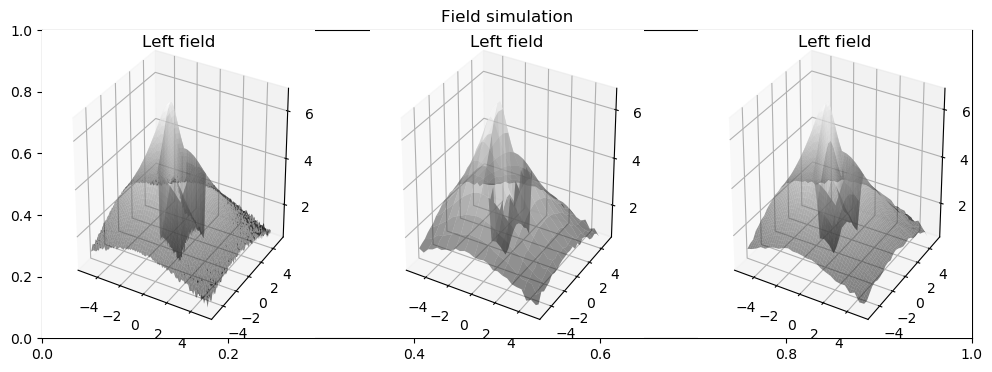

676


PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f7d54b41f50>

In [27]:
using PyPlot
using Interpolations

# sampling
x = -5:.4:5
y = -5:.4:5
n = length(x)
xn = yn = n

println(xn*yn)

xgrid = repmat(x, 1, xn)';
ygrid = repmat(y, 1, yn);

knots = (x, y)

# sampling
xo = -5:.1:5
yo = -5:.1:5
no = length(xo)
xno = yno = no

xgrido = repmat(xo, 1, xno)';
ygrido = repmat(yo, 1, yno);

type Antenna
    x::Float64
    y::Float64
end

# 
#          _
#          |
#      X1-X4--X2
#          |
#         X3
#

tg(x,y) = ((abs(x).<1) & (abs(y).<2))

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))
push!(antennas, Antenna(0, 0))

N_inputs = length(antennas)

# field + noise
field(a, x, y) = 1./(((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + 1).^(3/2))

# dump
tg(x, y) = ((abs(x).<1) & (abs(y).<2))

field_dump(a, x, y) = e.^(3*(a<4)*tg(x,y) + 3*(a>=4)*(!tg(x,y)))

# result
flogv(a, x, y) = log(900*field(a, x, y)./field_dump(a, x, y) .+ 1*rand(size(x)))

itp = []
for i = 1:N_inputs
    push!(itp, interpolate(knots, flogv(i, xgrid, ygrid), Gridded(Linear())))
end

# _flogv(a, x, y) = itp[a][x, y]
function _flogv(a, x, y)
    z = zeros(length(x))
    for c = 1:length(x)
        z[c] = itp[a][y[c], x[c]]
        # @printf("%d, %d -> %d\n", x[c], y[c], z[c])
    end
    z = reshape(z, size(x))
end

z1 = flogv(1, xgrid, ygrid)

fig = figure("An example", figsize=(12,4));
title("Field simulation")

ax = fig[:add_subplot](1,3,1, projection = "3d");
title("Left field")
z = flogv(1, xgrido, ygrido)
ax[:plot_surface](xgrido, ygrido, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.5, linewidth=0.2)

ax = fig[:add_subplot](1,3,2, projection = "3d");
title("Left field")
z = flogv(1, xgrid, ygrid)
ax[:plot_surface](xgrid, ygrid, z, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.5, linewidth=0.2)

ax = fig[:add_subplot](1,3,3, projection = "3d");
title("Left field")
zi = _flogv(1, xgrido, ygrido)
ax[:plot_surface](xgrido, ygrido, zi, rstride=2, cstride=2, cmap=ColorMap("gray"), alpha=0.5, linewidth=0.2)


In [28]:
function tg3(x, y)
    if ((abs(x)<1) && (abs(y)<2))
        return 1
    else
        if (abs(y)<2)
            if ((x>=1) && (x<2))
                return 2
            elseif ((x<=-1) && (x>-2))
                return 3
            else
                return 0
            end
        else
            if ((y<=-2) && (y>-3) && (abs(x)<2))
                return 4
            else
                return 0
            end
        end
        return 0
    end
end

function _gen_datain(x, y)
    len = N_inputs
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        rss = hcat(rss, flogv(i, x, y))
    end
    return rss
end

function gen_datain(x, y)
    len = N_inputs
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        rss = hcat(rss, _flogv(i, x, y))
    end
    return rss
end

function gen_dataout(x, y)
    len = length(x)
    out = [tg3(x[i], y[i]) for i in 1:len]
    return out
end

function gen_rand(n)
    out = 2*5*rand(2, n)-5
    return out
end

function gen_randn(n)
    out = 2.5*randn(2, n)
    return out
end


gen_randn (generic function with 1 method)

In [29]:
# Kinda like a C struct
type StandardScalar
    mean::Array{Float64,2}
    std::Array{Float64,2}
end

N_train = 20000

println("generating training data")
# Rxy = 2*5*rand(2, N_train)-5
Rxy = gen_randn(N_train)

X_train = gen_datain(Rxy[1,:], Rxy[2,:])'
y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
# std_scalar = StandardScalar(mean(X_train,2), std(X_train,2))
# X_train = (X_train .- std_scalar.mean) ./ std_scalar.std

# y_train = sparse(convert(Array{Int64}, y_train + 1), 1:N_train, [1 for i in 1:N_train])
;

generating training data


In [30]:
using NaiveBayes

p, n = size(X_train)
model = GaussianNB(unique(y_train), p)
# model = MultinomialNB(unique(y_train), p)
# model = HybridNB(unique(y_train))

fit(model, X_train, y_train)

GaussianNB(Dict(0=>12230,4=>1099,2=>1492,3=>1561,1=>3618))

In [31]:
mode = 0
if (mode == 1)
    N_test = 15000
    Rxy = gen_randn(N_test)
else
    xn = yn = 100;
    N_test = xn*yn
    x = linspace(-4, 4, xn)
    y = linspace(-4, 4, yn)

    x = reshape(repmat(x', xn, 1), 1, length(repmat(x', xn, 1)))
    y = reshape(repmat(y, 1, yn), 1, length(repmat(y, 1, yn)))
    Rxy = [x;y]
end

X_test = gen_datain(Rxy[1,:], Rxy[2,:])'
y_test = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
# X_test = (X_test .- std_scalar.mean) ./ std_scalar.std
# y_test = sparse(convert(Array{Int64}, y_test + 1),1:N_test, [1 for i in 1:N_test])

# y_proba = infer(architecture, X_test)
# mean(mapslices(x -> indmax(x), y_proba, 1)[:]  .==  mapslices(x -> indmax(x), full(y_test),1)[:])

y_pred = predict(model, X_test)
accuracy = mean(y_pred .== y_test)
println("Accuracy: $accuracy")


Accuracy: 0.8113


In [32]:
println("Prediction accuracy: ", mean(y_pred .== y_test))

function confusion_matrix(y_test::Array{Int64,1}, y_pred::Array{Int64,1}, N::Int64)
    # Generate confusion matrix
    cm = zeros(Int64,N,N)
    r = length(y_test)
    for i in 1:r
        # translate label to index
        true_class = y_test[i]
        pred_class = y_pred[i]
        # pred class is the row, true class is the column
        cm[pred_class+1, true_class+1] += 1
    end
    cm
end

confusion_matrix(y_test, y_pred, 5)

Prediction accuracy: 0.8113


5×5 Array{Int64,2}:
 6436  1046   67   66   76
    0     0    0    0    0
  135    64  581    0    5
  125    65    0  582    5
  204    25    2    2  514

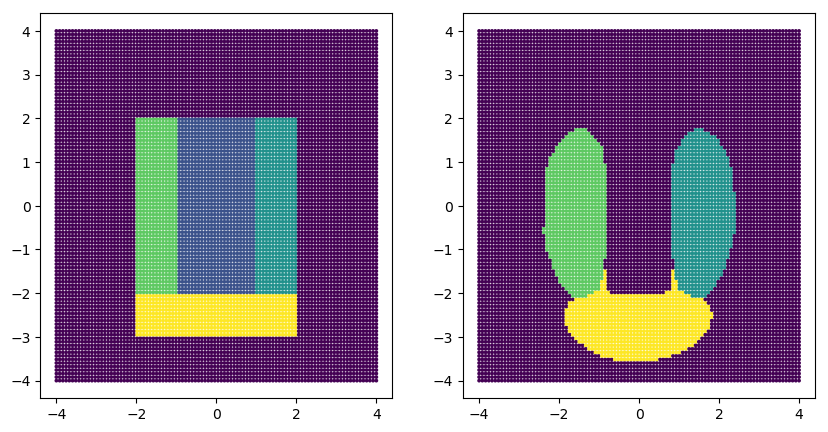

PyObject <matplotlib.collections.PathCollection object at 0x7f7d54607b50>

In [33]:
using PyPlot

fig = figure("An example", figsize=(10,5))

# ax = gca() # get current axes
ax[:set_xlim]((-4,4))
ax[:set_ylim]((-4,4))
ax = fig[:add_subplot](1,2,1)
scatter(Rxy[1,:], Rxy[2,:], c=y_test, alpha=1, s=30, edgecolors="None", marker=".")
ax = fig[:add_subplot](1,2,2)
scatter(Rxy[1,:], Rxy[2,:], c=y_pred, alpha=1, s=30, edgecolors="None", marker=".")

In [15]:
Pkg.update()

INFO: Updating METADATA...
INFO: Updating cache of DataFrames...
INFO: Updating cache of DataFrames...
INFO: Updating ANN master...
INFO: Computing changes...
INFO: No packages to install, update or remove
